In [22]:
import pandas as pd  # For data handling
import numpy as np   # For numerical computations
from plotnine import *  # For visualizations (ggplot2-style)
import xgboost as xgb # For XGBoost
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score
)
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm  # progress bar
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from joblib import parallel_backend
from tqdm_joblib import tqdm_joblib

In [23]:
# Loading Alzheimers dataset
pd.set_option('display.max_columns', None)
df = pd.read_csv('alzheimers_prediction_dataset (1).csv')
display(df.head())
print(f"Shape of df: {df.shape}")

,Country,Age,Gender,Education Level,BMI,Physical Activity Level,Smoking Status,Alcohol Consumption,Diabetes,Hypertension,Cholesterol Level,Family History of Alzheimer’s,Cognitive Test Score,Depression Level,Sleep Quality,Dietary Habits,Air Pollution Exposure,Employment Status,Marital Status,Genetic Risk Factor (APOE-ε4 allele),Social Engagement Level,Income Level,Stress Levels,Urban vs Rural Living,Alzheimer’s Diagnosis
0,Spain,90,Male,1,33.0,Medium,Never,Occasionally,No,No,Normal,No,90,Low,Poor,Healthy,High,Retired,Single,No,Low,Medium,High,Urban,No
1,Argentina,72,Male,7,29.9,Medium,Former,Never,No,No,Normal,No,65,Low,Good,Healthy,Medium,Unemployed,Widowed,No,High,Low,High,Urban,No
2,South Africa,86,Female,19,22.9,High,Current,Occasionally,No,Yes,Normal,No,43,High,Good,Average,Medium,Employed,Single,No,Low,Medium,High,Rural,No
3,China,53,Male,17,31.2,Low,Never,Regularly,Yes,No,Normal,No,81,Medium,Average,Healthy,Medium,Retired,Single,No,High,Medium,Low,Rural,No
4,Sweden,58,Female,3,30.0,High,Former,Never,Yes,No,Normal,No,49,High,Poor,Unhealthy,High,Employed,Married,No,Low,Medium,High,Rural,No


Shape of df: (74283, 25)


In [24]:
# Standardize column names
def standardize_column_names(df):
    df_copy = df.copy()
    
    # Clean column names
    df_copy.columns = (df_copy.columns
                      .str.lower()  # Convert to lowercase
                      .str.replace(r"[^\w\s]", "_", regex=True)  # Replace special chars with underscore
                      .str.replace(r"\s+", "_", regex=True)  # Replace spaces with underscore
                      .str.replace(r"_+", "_", regex=True)  # Replace multiple underscores with single
                      .str.strip("_"))  # Remove leading/trailing underscores
    
    return df_copy

# Apply standardization
df = standardize_column_names(df)
df

,country,age,gender,education_level,bmi,physical_activity_level,smoking_status,alcohol_consumption,diabetes,hypertension,cholesterol_level,family_history_of_alzheimer_s,cognitive_test_score,depression_level,sleep_quality,dietary_habits,air_pollution_exposure,employment_status,marital_status,genetic_risk_factor_apoe_ε4_allele,social_engagement_level,income_level,stress_levels,urban_vs_rural_living,alzheimer_s_diagnosis
0,Spain,90,Male,1,33.0,Medium,Never,Occasionally,No,No,Normal,No,90,Low,Poor,Healthy,High,Retired,Single,No,Low,Medium,High,Urban,No
1,Argentina,72,Male,7,29.9,Medium,Former,Never,No,No,Normal,No,65,Low,Good,Healthy,Medium,Unemployed,Widowed,No,High,Low,High,Urban,No
2,South Africa,86,Female,19,22.9,High,Current,Occasionally,No,Yes,Normal,No,43,High,Good,Average,Medium,Employed,Single,No,Low,Medium,High,Rural,No
3,China,53,Male,17,31.2,Low,Never,Regularly,Yes,No,Normal,No,81,Medium,Average,Healthy,Medium,Retired,Single,No,High,Medium,Low,Rural,No
4,Sweden,58,Female,3,30.0,High,Former,Never,Yes,No,Normal,No,49,High,Poor,Unhealthy,High,Employed,Married,No,Low,Medium,High,Rural,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74278,Russia,60,Female,3,22.6,High,Former,Never,No,No,High,No,42,Medium,Poor,Average,High,Unemployed,Widowed,No,Medium,High,Medium,Rural,No
74279,UK,58,Male,18,30.6,Low,Never,Occasionally,Yes,No,Normal,No,42,Low,Poor,Average,Medium,Unemployed,Single,No,Medium,High,High,Rural,No
74280,Spain,57,Female,13,28.2,Medium,Never,Regularly,No,No,High,Yes,61,Low,Good,Healthy,Low,Employed,Single,Yes,High,Low,Low,Rural,No
74281,Brazil,73,Female,7,29.0,Low,Never,Regularly,No,No,High,No,97,High,Good,Healthy,Low,Employed,Widowed,No,Low,Low,High,Rural,No


In [25]:
#Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

country                               0
age                                   0
gender                                0
education_level                       0
bmi                                   0
physical_activity_level               0
smoking_status                        0
alcohol_consumption                   0
diabetes                              0
hypertension                          0
cholesterol_level                     0
family_history_of_alzheimer_s         0
cognitive_test_score                  0
depression_level                      0
sleep_quality                         0
dietary_habits                        0
air_pollution_exposure                0
employment_status                     0
marital_status                        0
genetic_risk_factor_apoe_ε4_allele    0
social_engagement_level               0
income_level                          0
stress_levels                         0
urban_vs_rural_living                 0
alzheimer_s_diagnosis                 0


In [34]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

#encode the target variable if it's not already 0/1
print("Unique values in target before encoding:", df['alzheimer_s_diagnosis'].unique())

label_encoder = LabelEncoder()
df['alzheimer_s_diagnosis'] = label_encoder.fit_transform(df['alzheimer_s_diagnosis'])

print("Uniqe values in target after encoding:", df['alzheimer_s_diagnosis'].unique())
print("Target Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))



cat_cols = df.select_dtypes(include=["object", "bool"]).columns
print("Categorical columns to encode:", cat_cols.tolist())

df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

bool_cols = df_encoded.select_dtypes(include="bool").columns
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

df_encoded

Unique values in target before encoding: [0 1]
Uniqe values in target after encoding: [0 1]
Target Mapping: {np.int64(0): np.int64(0), np.int64(1): np.int64(1)}
Categorical columns to encode: ['country', 'gender', 'physical_activity_level', 'smoking_status', 'alcohol_consumption', 'diabetes', 'hypertension', 'cholesterol_level', 'family_history_of_alzheimer_s', 'depression_level', 'sleep_quality', 'dietary_habits', 'air_pollution_exposure', 'employment_status', 'marital_status', 'genetic_risk_factor_apoe_ε4_allele', 'social_engagement_level', 'income_level', 'stress_levels', 'urban_vs_rural_living']


,age,education_level,bmi,cognitive_test_score,alzheimer_s_diagnosis,country_Australia,country_Brazil,country_Canada,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Mexico,country_Norway,country_Russia,country_Saudi Arabia,country_South Africa,country_South Korea,country_Spain,country_Sweden,country_UK,country_USA,gender_Male,physical_activity_level_Low,physical_activity_level_Medium,smoking_status_Former,smoking_status_Never,alcohol_consumption_Occasionally,alcohol_consumption_Regularly,diabetes_Yes,hypertension_Yes,cholesterol_level_Normal,family_history_of_alzheimer_s_Yes,depression_level_Low,depression_level_Medium,sleep_quality_Good,sleep_quality_Poor,dietary_habits_Healthy,dietary_habits_Unhealthy,air_pollution_exposure_Low,air_pollution_exposure_Medium,employment_status_Retired,employment_status_Unemployed,marital_status_Single,marital_status_Widowed,genetic_risk_factor_apoe_ε4_allele_Yes,social_engagement_level_Low,social_engagement_level_Medium,income_level_Low,income_level_Medium,stress_levels_Low,stress_levels_Medium,urban_vs_rural_living_Urban
0,90,1,33.0,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,1,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1
1,72,7,29.9,65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1
2,86,19,22.9,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0
3,53,17,31.2,81,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,1,0,0
4,58,3,30.0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74278,60,3,22.6,42,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0
74279,58,18,30.6,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0
74280,57,13,28.2,61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,1,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0
74281,73,7,29.0,97,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0


In [29]:
# Inspect all columns with limited unique values (likely categorical)
potential_cats = [col for col in df.columns if df[col].nunique() <= 10 and df[col].dtype != "float64"]

print("Potential categorical columns:", potential_cats)

# Ensure target is encoded
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['alzheimer_s_diagnosis'] = label_encoder.fit_transform(df['alzheimer_s_diagnosis'])

# Encode categoricals more robustly
df_encoded = pd.get_dummies(df, columns=potential_cats, drop_first=True)

# Convert any booleans to int just in case
bool_cols = df_encoded.select_dtypes(include="bool").columns
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

print("Final shape after encoding:", df_encoded.shape)
df_encoded.head()


Potential categorical columns: ['gender', 'physical_activity_level', 'smoking_status', 'alcohol_consumption', 'diabetes', 'hypertension', 'cholesterol_level', 'family_history_of_alzheimer_s', 'depression_level', 'sleep_quality', 'dietary_habits', 'air_pollution_exposure', 'employment_status', 'marital_status', 'genetic_risk_factor_apoe_ε4_allele', 'social_engagement_level', 'income_level', 'stress_levels', 'urban_vs_rural_living', 'alzheimer_s_diagnosis']
Final shape after encoding: (74283, 37)


,country,age,education_level,bmi,cognitive_test_score,gender_Male,physical_activity_level_Low,physical_activity_level_Medium,smoking_status_Former,smoking_status_Never,alcohol_consumption_Occasionally,alcohol_consumption_Regularly,diabetes_Yes,hypertension_Yes,cholesterol_level_Normal,family_history_of_alzheimer_s_Yes,depression_level_Low,depression_level_Medium,sleep_quality_Good,sleep_quality_Poor,dietary_habits_Healthy,dietary_habits_Unhealthy,air_pollution_exposure_Low,air_pollution_exposure_Medium,employment_status_Retired,employment_status_Unemployed,marital_status_Single,marital_status_Widowed,genetic_risk_factor_apoe_ε4_allele_Yes,social_engagement_level_Low,social_engagement_level_Medium,income_level_Low,income_level_Medium,stress_levels_Low,stress_levels_Medium,urban_vs_rural_living_Urban,alzheimer_s_diagnosis_1
0,Spain,90,1,33.0,90,1,0,1,0,1,1,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0
1,Argentina,72,7,29.9,65,1,0,1,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0
2,South Africa,86,19,22.9,43,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0
3,China,53,17,31.2,81,1,1,0,0,1,0,1,1,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,1,0,0,0
4,Sweden,58,3,30.0,49,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [36]:
#Defining features and target
X = df_encoded.drop(columns=('alzheimer_s_diagnosis'))
y = df_encoded['alzheimer_s_diagnosis']

In [37]:
#Train/test split
x_train, x_test, y_train, y_test = train_test_split(
   X, y, test_size = 0.2, stratify=y, random_state=42
)

#Pipeline

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, class_weight="balanced"))

])

#Fitting models
pipe.fit(x_train, y_train)

#Evaluate
print("Train accuracy:", pipe.score(x_train, y_train))
print("Test accuracy:", pipe.score(x_test, y_test))

#Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc")
print("Cross-Validated AUC:", scores.mean())


Train accuracy: 0.7138626190556322
Test accuracy: 0.7162953489937404
Cross-Validated AUC: 0.7902739885758407



Confusion matrix:


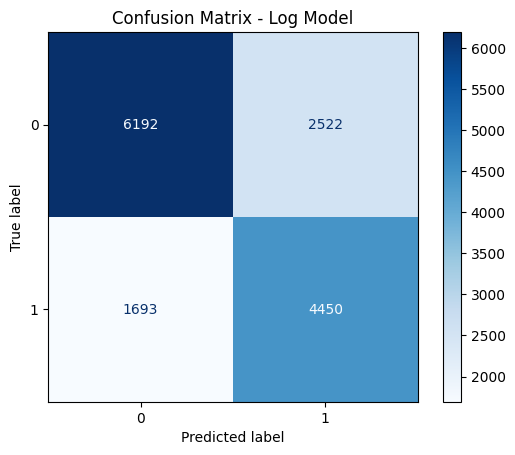


Accuracy:
0.7162953489937404
              precision    recall  f1-score   support

           0       0.79      0.71      0.75      8714
           1       0.64      0.72      0.68      6143

    accuracy                           0.72     14857
   macro avg       0.71      0.72      0.71     14857
weighted avg       0.72      0.72      0.72     14857



In [38]:
y_pred = pipe.predict(x_test)



print("\nConfusion matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Log Model")
plt.show()
print("\nAccuracy:")
print(accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

#Decision Tree Model


In [39]:
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(x_train, y_train)
y_pred_dt = dt.predict(x_test)


print("\nDecision Tree")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("ROC AUC:", roc_auc_score(y_test, dt.predict_proba(x_test)[:,1]))
print(classification_report(y_test, y_pred_dt))



Decision Tree
Accuracy: 0.7295550918758834
ROC AUC: 0.800965510956807
              precision    recall  f1-score   support

           0       0.80      0.72      0.76      8714
           1       0.65      0.74      0.69      6143

    accuracy                           0.73     14857
   macro avg       0.72      0.73      0.73     14857
weighted avg       0.74      0.73      0.73     14857




Confusion matrix:


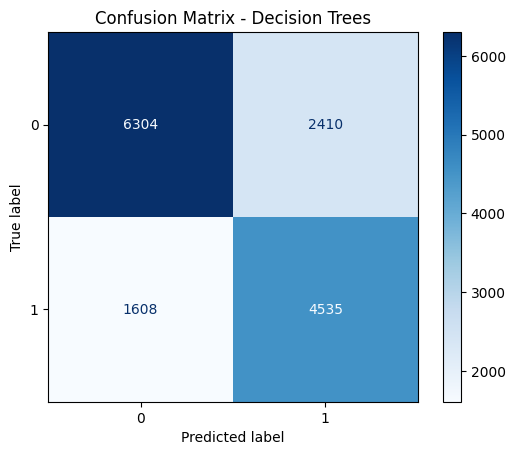


Accuracy:
0.7295550918758834
              precision    recall  f1-score   support

           0       0.80      0.72      0.76      8714
           1       0.65      0.74      0.69      6143

    accuracy                           0.73     14857
   macro avg       0.72      0.73      0.73     14857
weighted avg       0.74      0.73      0.73     14857



In [40]:
print("\nConfusion matrix:")
cm = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Decision Trees")
plt.show()
print("\nAccuracy:")
print(accuracy_score(y_test, y_pred_dt))

print(classification_report(y_test, y_pred_dt))

#Random Forest

In [41]:
rf = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, class_weight="balanced")
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)

print("\n Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, rf.predict_proba(x_test)[0:,1]))
print(classification_report(y_test, y_pred_rf))


 Random Forest
Accuracy: 0.7234300329810863
ROC AUC: 0.7994172325694429
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      8714
           1       0.68      0.63      0.65      6143

    accuracy                           0.72     14857
   macro avg       0.71      0.71      0.71     14857
weighted avg       0.72      0.72      0.72     14857




Confusion matrix:


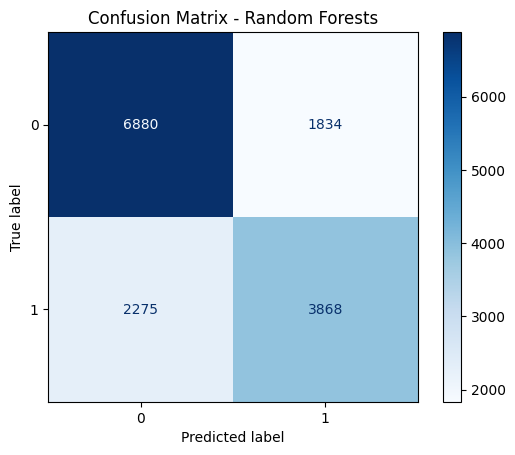


Accuracy:
0.7234300329810863
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      8714
           1       0.68      0.63      0.65      6143

    accuracy                           0.72     14857
   macro avg       0.71      0.71      0.71     14857
weighted avg       0.72      0.72      0.72     14857



In [42]:
print("\nConfusion matrix:")
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Random Forests")
plt.show()
print("\nAccuracy:")
print(accuracy_score(y_test, y_pred_rf))

print(classification_report(y_test, y_pred_rf))

XGBoost Model

In [43]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,  # Changed from 0.5 to a valid integer
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)
xgb.fit(x_train, y_train)
y_pred_xgb = xgb.predict(x_test)

print("\n XGBoost")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Roc AUC:", roc_auc_score(y_test, xgb.predict_proba(x_test)[:, 1]))
print(classification_report(y_test, y_pred_xgb))


 XGBoost
Accuracy: 0.7307666419869422
Roc AUC: 0.8074830307627661
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      8714
           1       0.67      0.69      0.68      6143

    accuracy                           0.73     14857
   macro avg       0.72      0.73      0.72     14857
weighted avg       0.73      0.73      0.73     14857




Confusion matrix:


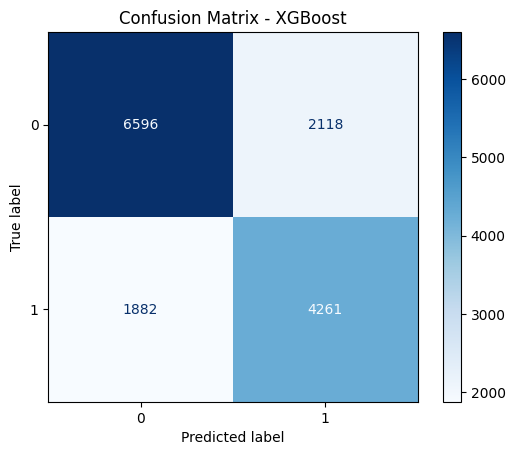


Accuracy:
0.7307666419869422
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      8714
           1       0.67      0.69      0.68      6143

    accuracy                           0.73     14857
   macro avg       0.72      0.73      0.72     14857
weighted avg       0.73      0.73      0.73     14857



In [44]:
print("\nConfusion matrix:")
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.show()
print("\nAccuracy:")
print(accuracy_score(y_test, y_pred_xgb))

print(classification_report(y_test, y_pred_xgb))

#Cross Validation


In [45]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for model, name in [(dt, "Decision Trees"), (rf, "Random Forests"), (xgb, "XGBoost")]:
  cv_scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc")
  print(f"{name}, CV AUC: {cv_scores.mean():.3f}")

Decision Trees, CV AUC: 0.796
Random Forests, CV AUC: 0.797
XGBoost, CV AUC: 0.804


#ROC

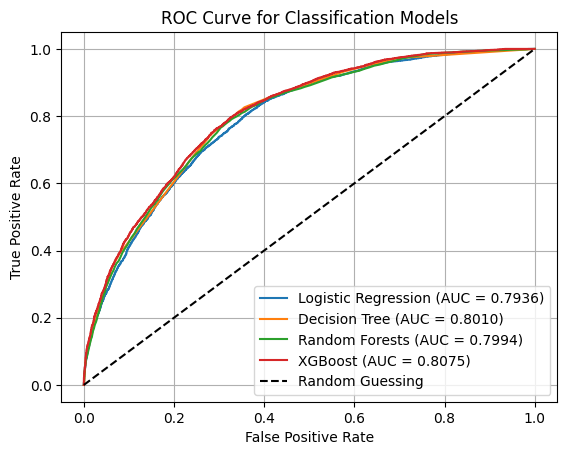

In [46]:
#predicted probabilities
y_pred_proba_logreg = pipe.predict_proba(x_test)[:, 1]
y_pred_proba_dt = dt.predict_proba(x_test)[:, 1]
y_pred_proba_rf = rf.predict_proba(x_test)[:, 1]
y_pred_proba_xgb = xgb.predict_proba(x_test)[:, 1]


#Calc ROC and AUC
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_proba_logreg)
auc_logreg = roc_auc_score(y_test, y_pred_proba_logreg)

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)
auc_dt = roc_auc_score(y_test, y_pred_proba_dt)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

#Plot
plt.figure()
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {auc_logreg:.4f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.4f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forests (AUC = {auc_rf:.4f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.4f})')

plt.plot([0,1], [0,1], 'k--', label="Random Guessing")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Classification Models')
plt.legend()
plt.grid(True)
plt.show()

XGBoost is the best performing model. Below we will tune it to hopefully acheive better accuracy.

In [47]:
#parameter grid for XGBoost

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],      # number of trees
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.3],  # contribution of each tree
    'max_depth': [4, 5, 6],                         # tree complexity
    'subsample': [1],                               # fraction of training samples randomly selected
    'colsample_bytree': [1],                        # fraction of features randomly chosen for each tree
    'min_child_weight': [1, 3, 5, 7],               # min number of samples in each child node
    'gamma': [0, 0.1, 0.2]                          # loss reduction required to split tree
}

#XGB Classifier
xgb_tuning = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False
)

#Cross Val
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


#calc total combinations
total_combos = 1
for param_values in param_grid.values():
    total_combos *=len(param_values)


print("Starting Grid Search")

#grid search
#with tqdm_joblib(tqdm(desc="XBGoost Grid Search", total=total_combos * 5)) as progress_bar:
    
grid_search = GridSearchCV(
            estimator=xgb_tuning,
            param_grid=param_grid,
            scoring='roc_auc',
            cv=cv,
            n_jobs=-1,
            verbose=2
        )

grid_search.fit(x_train, y_train)


best_params = grid_search.best_params_
best_scores = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_scores)

Starting Grid Search
Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Best Parameters: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1}
Best Score: 0.8029502559116629


c:\Users\patbe\Machine Leaning Project\ml_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:39:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



In [48]:
# Get the best estimator and extract n_estimators
best_estimator = grid_search.best_estimator_
best_rounds = best_estimator.get_params()['n_estimators']

print("Best Estimator:", best_estimator)
print("Best Rounds (n_estimators):", best_rounds)

Best Estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)
Best Rounds (n_estimators): 100


In [49]:
final_xgb_tuned = XGBClassifier(
    **best_params,
    eval_metric='logloss',
    use_label_encode=False,
    random_state=42
)

final_xgb_tuned.fit(x_train, y_train)

y_pred_tuned = final_xgb_tuned.predict(x_test)
y_pred_proba_tuned = final_xgb_tuned.predict_proba(x_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("Test ROC AUC:", roc_auc_score(y_test, y_pred_proba_tuned))
print(classification_report(y_test, y_pred_tuned))

c:\Users\patbe\Machine Leaning Project\ml_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:39:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encode" } are not used.



Test Accuracy: 0.7304974086289291
Test ROC AUC: 0.8076195333982364
              precision    recall  f1-score   support

           0       0.79      0.74      0.76      8714
           1       0.66      0.72      0.69      6143

    accuracy                           0.73     14857
   macro avg       0.72      0.73      0.73     14857
weighted avg       0.74      0.73      0.73     14857




Confusion matrix:


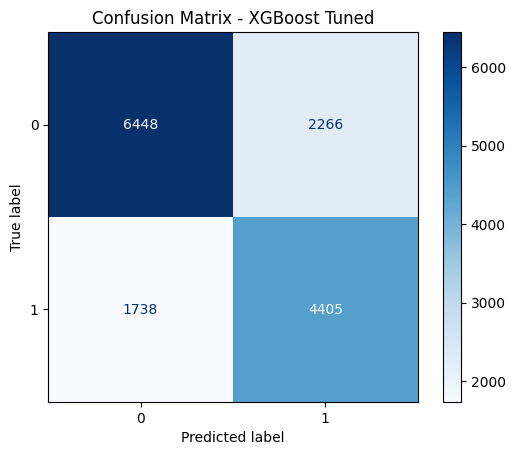


Accuracy:
0.7304974086289291


In [50]:
print("\nConfusion matrix:")
cm = confusion_matrix(y_test, y_pred_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - XGBoost Tuned")
plt.show()
print("\nAccuracy:")
print(accuracy_score(y_test, y_pred_tuned))

#New ROC Curve

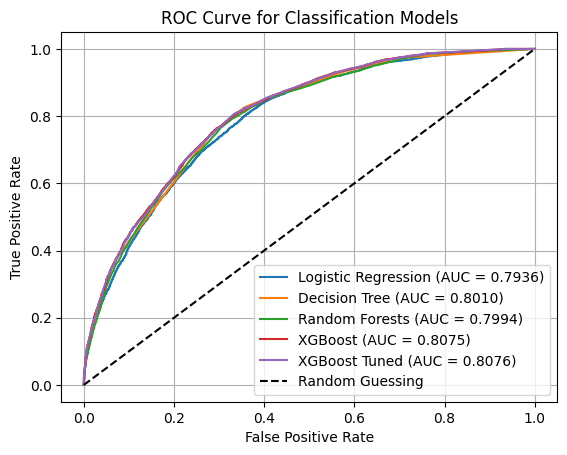

In [51]:
fpr_xgb_tuned, tpr_xgb_tuned, _ = roc_curve(y_test, y_pred_proba_tuned)
auc_xgb_tuned = roc_auc_score(y_test, y_pred_proba_tuned)

#Plot
plt.figure()
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {auc_logreg:.4f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.4f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forests (AUC = {auc_rf:.4f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.4f})')
plt.plot(fpr_xgb_tuned, tpr_xgb_tuned, label=f'XGBoost Tuned (AUC = {auc_xgb_tuned:.4f})')


plt.plot([0,1], [0,1], 'k--', label="Random Guessing")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Classification Models')
plt.legend()
plt.grid(True)
plt.show()

#Feature Importance

In [52]:
import pandas as pd

importances = final_xgb_tuned.feature_importances_

feat_imp = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

feat_imp



,Feature,Importance
0,age,0.509316
46,genetic_risk_factor_apoe_ε4_allele_Yes,0.115417
33,family_history_of_alzheimer_s_Yes,0.054270
13,country_Mexico,0.021261
17,country_South Africa,0.021253
5,country_Brazil,0.019008
10,country_India,0.018813
14,country_Norway,0.018041
20,country_Sweden,0.017178
15,country_Russia,0.016965


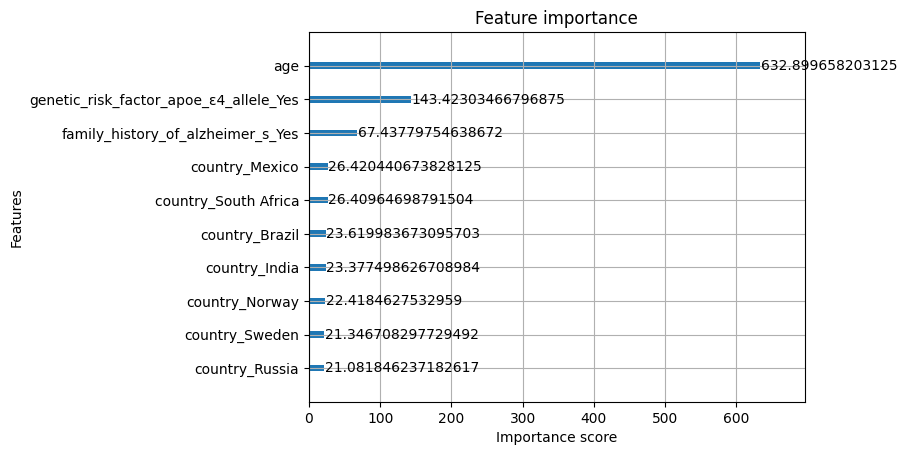

In [53]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(final_xgb_tuned, importance_type="gain", max_num_features=10)
plt.show()


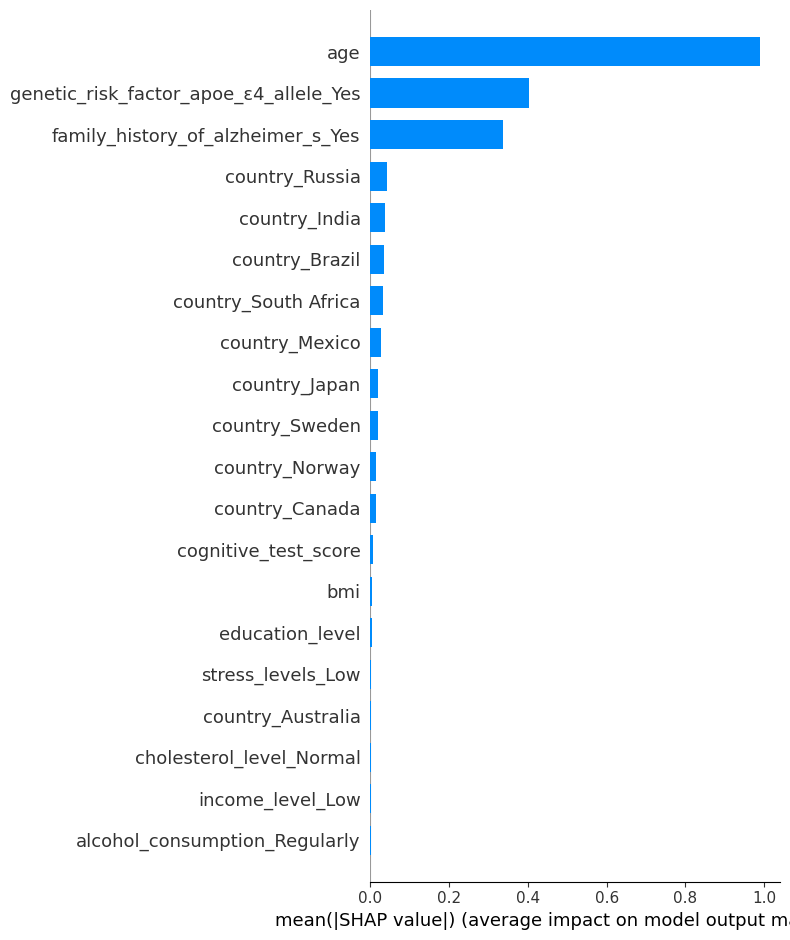

In [54]:
import shap

explainer = shap.TreeExplainer(final_xgb_tuned)
shap_values = explainer.shap_values(x_train)

shap.summary_plot(shap_values, x_train, plot_type="bar")

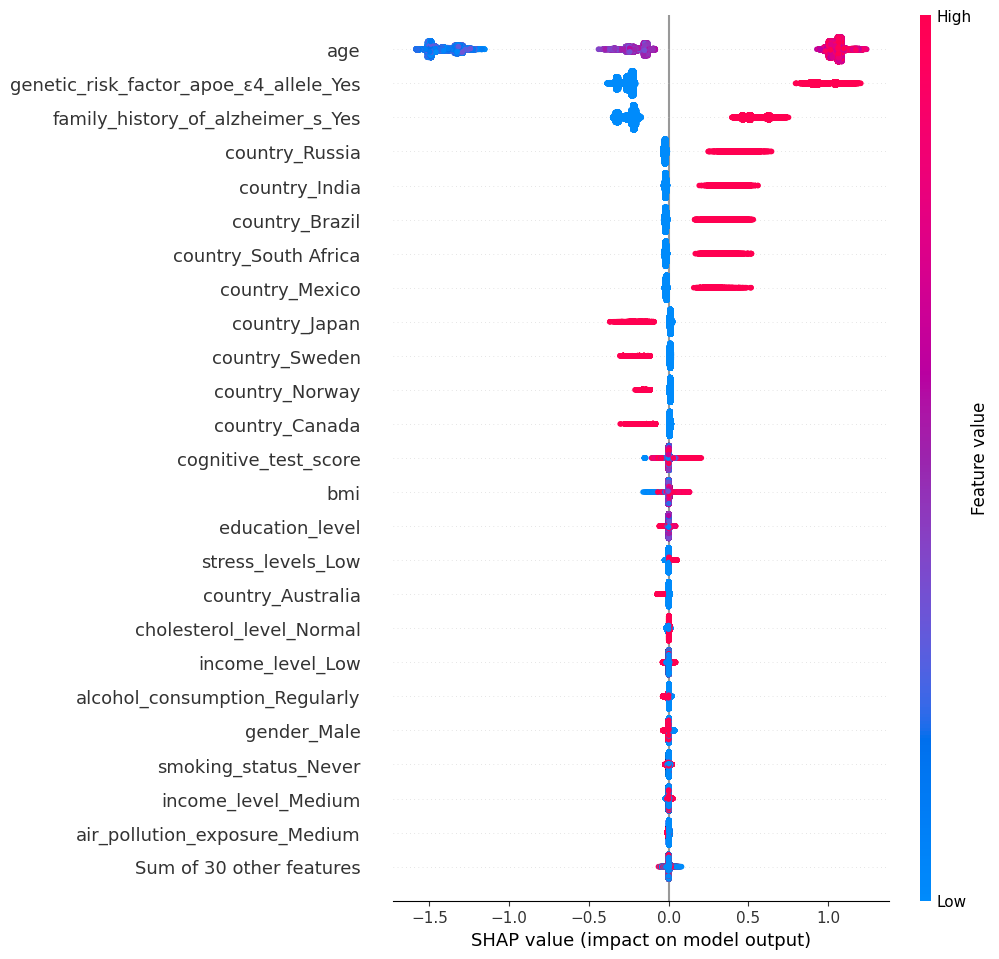

In [55]:

explainer = shap.TreeExplainer(final_xgb_tuned)
shap_values = explainer(x_train)

# Interactive JS init
shap.initjs()

# Beeswarm for binary
shap.plots.beeswarm(shap_values, max_display=25)  # matplotlib figure

In [56]:
#Loading Tech Dataset
tech_df = pd.read_csv('Tech_Use_Stress_Wellness.csv')
tech_df

,user_id,age,gender,daily_screen_time_hours,phone_usage_hours,laptop_usage_hours,tablet_usage_hours,tv_usage_hours,social_media_hours,work_related_hours,entertainment_hours,gaming_hours,sleep_duration_hours,sleep_quality,mood_rating,stress_level,physical_activity_hours_per_week,location_type,mental_health_score,uses_wellness_apps,eats_healthy,caffeine_intake_mg_per_day,weekly_anxiety_score,weekly_depression_score,mindfulness_minutes_per_day
0,1,53,Male,6.8,2.9,2.1,0.5,2.0,2.3,3.0,2.3,2.2,7.1,4.0,5.6,3,4.4,Rural,79.0,True,True,150.4,7.0,3.0,14.0
1,2,66,Female,4.1,2.1,1.6,0.4,0.8,2.8,3.5,2.0,1.6,6.8,4.0,6.0,4,4.1,Rural,71.0,True,True,124.1,7.0,10.0,15.5
2,3,43,Male,4.7,3.6,0.0,0.5,1.4,3.7,3.6,1.0,0.9,6.0,4.0,4.3,6,1.4,Urban,67.0,True,True,218.3,11.0,7.0,19.5
3,4,29,Female,6.0,4.5,0.0,0.2,1.3,4.5,4.0,0.8,0.3,7.3,4.0,1.3,10,0.0,Rural,55.0,True,True,133.7,17.0,14.0,13.9
4,5,57,Male,6.7,3.4,2.0,0.8,1.2,3.8,3.5,1.2,2.0,7.0,4.0,3.6,6,2.8,Urban,62.0,False,False,192.8,5.0,8.0,26.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,17,Female,7.0,2.2,0.9,0.5,2.3,4.5,4.1,1.3,1.1,5.9,4.0,1.0,10,0.0,Rural,55.0,False,False,233.0,18.0,16.0,11.8
4996,4997,42,Female,1.9,1.5,1.5,0.2,0.0,1.7,2.7,2.7,2.5,8.2,4.0,7.7,2,5.3,Rural,79.0,False,True,159.3,2.0,1.0,13.0
4997,4998,20,Female,6.3,1.5,2.6,0.6,0.8,4.5,3.9,1.4,1.0,7.7,4.0,1.0,10,0.1,Rural,47.0,False,False,83.0,12.0,17.0,9.1
4998,4999,58,Male,6.2,3.5,1.2,1.3,1.3,3.8,3.7,1.3,1.7,7.6,3.0,6.7,5,4.3,Urban,76.0,False,False,108.0,6.0,7.0,16.0


#Similar Columns in Alz and Tech Datasets

Physical Activity

Diet Quality

Sleep Quality

Depression

Age

Gender

In [57]:
#Extracting Similar Variables
tech_similar_cols = ['age', 'gender', 'physical_activity_hours_per_week', 'eats_healthy', 'sleep_quality', 'weekly_depression_score', 'stress_level']

tech_similar_df = tech_df[tech_similar_cols].copy()
tech_similar_df['eats_healthy'] = tech_similar_df['eats_healthy'].astype(int)
tech_similar_df['gender'] = tech_similar_df['gender'].map({'Male': True, 'Female': False})
tech_similar_df = tech_similar_df.dropna(subset=['gender'])

tech_similar_df['gender'] = tech_similar_df['gender'].astype(int)
tech_similar_df

,age,gender,physical_activity_hours_per_week,eats_healthy,sleep_quality,weekly_depression_score,stress_level
0,53,1,4.4,1,4.0,3.0,3
1,66,0,4.1,1,4.0,10.0,4
2,43,1,1.4,1,4.0,7.0,6
3,29,0,0.0,1,4.0,14.0,10
4,57,1,2.8,0,4.0,8.0,6
...,...,...,...,...,...,...,...
4995,17,0,0.0,0,4.0,16.0,10
4996,42,0,5.3,1,4.0,1.0,2
4997,20,0,0.1,0,4.0,17.0,10
4998,58,1,4.3,0,3.0,7.0,5


In [58]:
#scale columns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

tech_similar_scaled = scaler.fit_transform(tech_similar_df)

tech_similar_df_scaled = pd.DataFrame(
    tech_similar_scaled,
    columns=tech_similar_df.columns,
    index=tech_similar_df.index
)


print("Original data:")
print(tech_similar_df.head())
print("\nOriginal data statistics:")
print(tech_similar_df.describe())

print("\nScaled data:")
print(tech_similar_df_scaled.head())
print("\nScaled data statistics:")
print(tech_similar_df_scaled.describe())

# Verify scaling worked (should have mean ~0 and std ~1)
print("\nScaled data means (should be close to 0):")
print(tech_similar_df_scaled.mean())
print("\nScaled data standard deviations (should be close to 1):")
print(tech_similar_df_scaled.std())
tech_similar_df_scaled

Original data:
   age  gender  physical_activity_hours_per_week  eats_healthy  sleep_quality  \
0   53       1                               4.4             1            4.0   
1   66       0                               4.1             1            4.0   
2   43       1                               1.4             1            4.0   
3   29       0                               0.0             1            4.0   
4   57       1                               2.8             0            4.0   

   weekly_depression_score  stress_level  
0                      3.0             3  
1                     10.0             4  
2                      7.0             6  
3                     14.0            10  
4                      8.0             6  

Original data statistics:
               age       gender  physical_activity_hours_per_week  \
count  4805.000000  4805.000000                       4805.000000   
mean     44.719875     0.509053                          2.664787   
std   

,age,gender,physical_activity_hours_per_week,eats_healthy,sleep_quality,weekly_depression_score,stress_level
0,0.480323,0.982055,0.758211,0.989442,-0.013748,-0.961089,-0.926419
1,1.234442,-1.018273,0.627124,0.989442,-0.013748,0.533627,-0.583842
2,-0.099768,0.982055,-0.552655,0.989442,-0.013748,-0.106965,0.101312
3,-0.911896,-1.018273,-1.164393,0.989442,-0.013748,1.387751,1.471619
4,0.712360,0.982055,0.059082,-1.010671,-0.013748,0.106566,0.101312
...,...,...,...,...,...,...,...
4995,-1.608006,-1.018273,-1.164393,-1.010671,-0.013748,1.814813,1.471619
4996,-0.157778,-1.018273,1.151471,0.989442,-0.013748,-1.388151,-1.268996
4997,-1.433979,-1.018273,-1.120698,-1.010671,-0.013748,2.028344,1.471619
4998,0.770369,0.982055,0.714515,-1.010671,-1.515141,-0.106965,-0.241265


In [59]:
#model to predict stress level. Probably not going to perform well lol

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
import xgboost as xgb


X_sim = tech_similar_df_scaled.drop('stress_level', axis=1)
y_sim = tech_similar_df_scaled['stress_level']

print("Features for stress prediction:")
print(X_sim.columns.tolist())
print(f"Features shape: {X_sim.shape}")
print(f"Target shape: {y_sim.shape}")


#Train test split
X_sim_train, X_sim_test, y_sim_train, y_sim_test = train_test_split(
    X_sim, y_sim, test_size=0.2, random_state=42
)


#train xgb model
stress_predict_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

stress_predict_model.fit(X_sim_train, y_sim_train)



#predictions
y_sim_pred = stress_predict_model.predict(X_sim_test)


# Convert predictions back to original 1-10 scale for evaluation
# Get the scaler parameters for stress_level
stress_mean = tech_similar_df['stress_level'].mean()
stress_std = tech_similar_df['stress_level'].std()

# Inverse transform predictions and actual values
y_sim_pred_original = y_sim_pred * stress_std + stress_mean
y_sim_test_original = y_sim_test * stress_std + stress_mean

# Round to 1-10 scale
y_sim_pred_rounded = np.clip(np.round(y_sim_pred_original), 1, 10)
y_sim_test_rounded = np.clip(np.round(y_sim_test_original), 1, 10)

# Evaluate using original scale
mae_sim = mean_absolute_error(y_sim_test_original, y_sim_pred_original)
rmse_sim = np.sqrt(mean_squared_error(y_sim_test_original, y_sim_pred_original))
r2_sim = r2_score(y_sim_test_original, y_sim_pred_original)
accuracy_sim = accuracy_score(y_sim_test_rounded, y_sim_pred_rounded)

print("\n=== Stress Prediction Model (4 scaled columns) ===")
print(f"MAE: {mae_sim:.3f}")
print(f"RMSE: {rmse_sim:.3f}")
print(f"R²: {r2_sim:.3f}")
print(f"Accuracy (after rounding): {accuracy_sim:.3f}")

# Save scaler parameters for later use with Alzheimer's data
print(f"\nScaler parameters to save:")
print(f"Stress mean: {stress_mean:.3f}")
print(f"Stress std: {stress_std:.3f}")

Features for stress prediction:
['age', 'gender', 'physical_activity_hours_per_week', 'eats_healthy', 'sleep_quality', 'weekly_depression_score']
Features shape: (4805, 6)
Target shape: (4805,)

=== Stress Prediction Model (4 scaled columns) ===
MAE: 0.920
RMSE: 1.164
R²: 0.838
Accuracy (after rounding): 0.347

Scaler parameters to save:
Stress mean: 5.704
Stress std: 2.919


C:\Users\patbe\AppData\Local\Temp\ipykernel_41292\1695018745.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



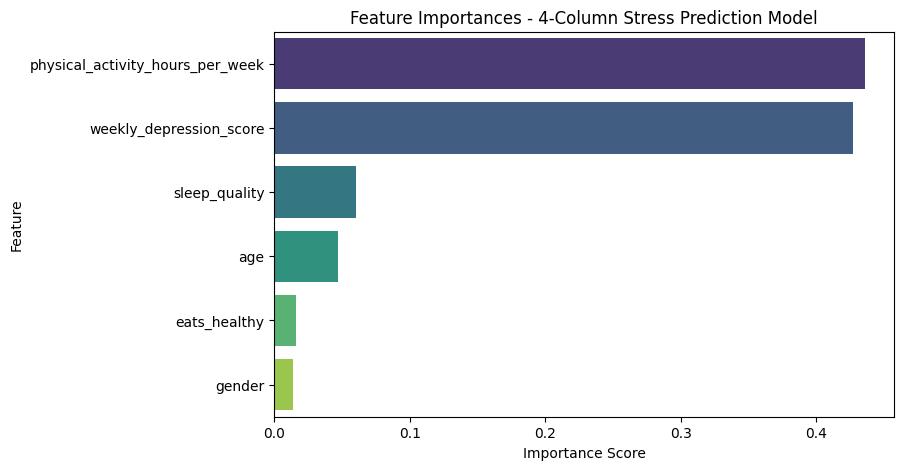


Feature Importance Rankings:
                            Feature  Importance
2  physical_activity_hours_per_week    0.435752
5           weekly_depression_score    0.427096
4                     sleep_quality    0.060023
0                               age    0.047378
3                      eats_healthy    0.015825
1                            gender    0.013926


In [60]:
#Visualizing Feature Importance

import seaborn as sns
import matplotlib.pyplot as plt

# Feature Importance
importances_sim = stress_predict_model.feature_importances_
feature_names_sim = X_sim_train.columns

feat_imp_sim_df = pd.DataFrame({
    "Feature": feature_names_sim,
    "Importance": importances_sim
}).sort_values(by="Importance", ascending=False)


plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=feat_imp_sim_df, palette="viridis")
plt.title("Feature Importances - 4-Column Stress Prediction Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

print("\nFeature Importance Rankings:")
print(feat_imp_sim_df)

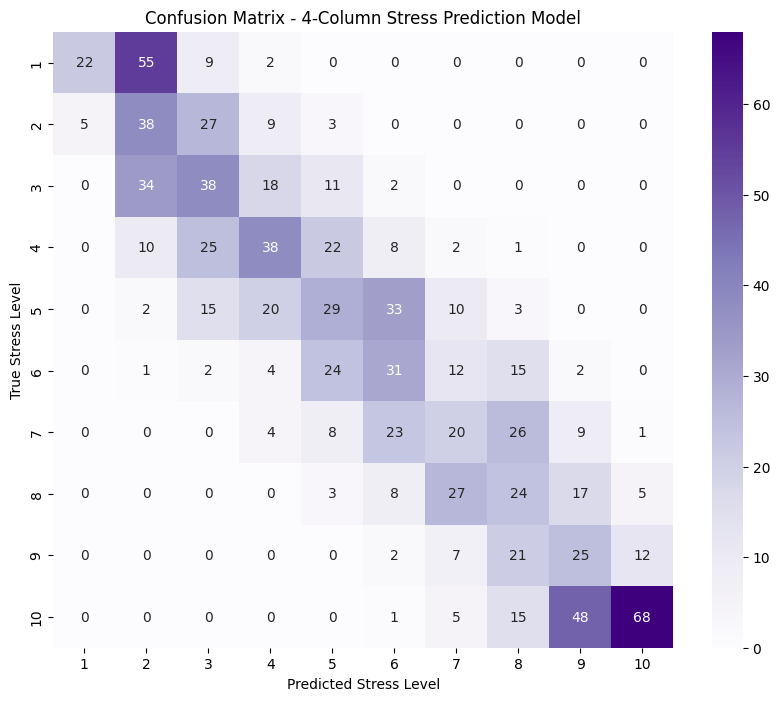

In [61]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

cm_stress_sim = confusion_matrix(y_sim_test_rounded, y_sim_pred_rounded, labels=range(1,11))

plt.figure(figsize=(10,8))
sns.heatmap(cm_stress_sim, annot=True, fmt="d", cmap="Purples", 
            xticklabels=range(1,11), yticklabels=range(1,11))
plt.xlabel("Predicted Stress Level")
plt.ylabel("True Stress Level")
plt.title("Confusion Matrix - 4-Column Stress Prediction Model")
plt.show()

In [62]:
print(df.columns)
df2 = df.copy()

Index(['country', 'age', 'gender', 'education_level', 'bmi',
       'physical_activity_level', 'smoking_status', 'alcohol_consumption',
       'diabetes', 'hypertension', 'cholesterol_level',
       'family_history_of_alzheimer_s', 'cognitive_test_score',
       'depression_level', 'sleep_quality', 'dietary_habits',
       'air_pollution_exposure', 'employment_status', 'marital_status',
       'genetic_risk_factor_apoe_ε4_allele', 'social_engagement_level',
       'income_level', 'stress_levels', 'urban_vs_rural_living',
       'alzheimer_s_diagnosis'],
      dtype='object')


In [63]:
df2['dietary_habits'] = df2['dietary_habits'].map({"Healthy": 2, "Average": 1, "Unhealthy": 0})
df2['physical_activity_level'] = df2['physical_activity_level'].map({"High": 2, "Medium": 1, "Low": 0})
df2['depression_level'] = df2['depression_level'].map({"High": 2, "Medium": 1, "Low": 0})
df2['sleep_quality'] = df2['sleep_quality'].map({"Good": 2, "Average": 1, "Poor": 0})
df2

,country,age,gender,education_level,bmi,physical_activity_level,smoking_status,alcohol_consumption,diabetes,hypertension,cholesterol_level,family_history_of_alzheimer_s,cognitive_test_score,depression_level,sleep_quality,dietary_habits,air_pollution_exposure,employment_status,marital_status,genetic_risk_factor_apoe_ε4_allele,social_engagement_level,income_level,stress_levels,urban_vs_rural_living,alzheimer_s_diagnosis
0,Spain,90,Male,1,33.0,1,Never,Occasionally,No,No,Normal,No,90,0,0,2,High,Retired,Single,No,Low,Medium,High,Urban,0
1,Argentina,72,Male,7,29.9,1,Former,Never,No,No,Normal,No,65,0,2,2,Medium,Unemployed,Widowed,No,High,Low,High,Urban,0
2,South Africa,86,Female,19,22.9,2,Current,Occasionally,No,Yes,Normal,No,43,2,2,1,Medium,Employed,Single,No,Low,Medium,High,Rural,0
3,China,53,Male,17,31.2,0,Never,Regularly,Yes,No,Normal,No,81,1,1,2,Medium,Retired,Single,No,High,Medium,Low,Rural,0
4,Sweden,58,Female,3,30.0,2,Former,Never,Yes,No,Normal,No,49,2,0,0,High,Employed,Married,No,Low,Medium,High,Rural,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74278,Russia,60,Female,3,22.6,2,Former,Never,No,No,High,No,42,1,0,1,High,Unemployed,Widowed,No,Medium,High,Medium,Rural,0
74279,UK,58,Male,18,30.6,0,Never,Occasionally,Yes,No,Normal,No,42,0,0,1,Medium,Unemployed,Single,No,Medium,High,High,Rural,0
74280,Spain,57,Female,13,28.2,1,Never,Regularly,No,No,High,Yes,61,0,2,2,Low,Employed,Single,Yes,High,Low,Low,Rural,0
74281,Brazil,73,Female,7,29.0,0,Never,Regularly,No,No,High,No,97,2,2,2,Low,Employed,Widowed,No,Low,Low,High,Rural,0


In [64]:
#Attempting to apply trained model to our Alz dataset
# Extracting similar columns
alz_cols_sim = ['age', 'gender', 'depression_level', 'sleep_quality', 'dietary_habits', 'physical_activity_level']

alz_sim_df = df2[alz_cols_sim].copy()

alz_sim_df['gender'] = alz_sim_df['gender'].map({'Male': True, 'Female': False})
alz_sim_df['gender'] = alz_sim_df['gender'].astype(int)
alz_sim_df

,age,gender,depression_level,sleep_quality,dietary_habits,physical_activity_level
0,90,1,0,0,2,1
1,72,1,0,2,2,1
2,86,0,2,2,1,2
3,53,1,1,1,2,0
4,58,0,2,0,0,2
...,...,...,...,...,...,...
74278,60,0,1,0,1,2
74279,58,1,0,0,1,0
74280,57,0,0,2,2,1
74281,73,0,2,2,2,0


In [65]:
#Scaling Columns

alz_sim_scaled = scaler.fit_transform(alz_sim_df)

alz_sim_df_scaled = pd.DataFrame(
    alz_sim_scaled,
    columns=alz_sim_df.columns,
    index=alz_sim_df.index
)


print("Original Alzheimer's data:")
print(alz_sim_df.head())
print("\nOriginal Alzheimer's data statistics:")
print(alz_sim_df.describe())

print("\nScaled Alzheimer's data:")
print(alz_sim_df_scaled.head())
print("\nScaled Alzheimer's data statistics:")
print(alz_sim_df_scaled.describe())

alz_sim_means = alz_sim_df_scaled.mean()
alz_sim_std = alz_sim_df_scaled.std()

# Verify scaling worked (should have mean ~0 and std ~1)
print("\nScaled Alzheimer's data means (should be close to 0):")
print(alz_sim_means)
print("\nScaled Alzheimer's data standard deviations (should be close to 1):")
print(alz_sim_std)

alz_sim_df_scaled

Original Alzheimer's data:
   age  gender  depression_level  sleep_quality  dietary_habits  \
0   90       1                 0              0               2   
1   72       1                 0              2               2   
2   86       0                 2              2               1   
3   53       1                 1              1               2   
4   58       0                 2              0               0   

   physical_activity_level  
0                        1  
1                        1  
2                        2  
3                        0  
4                        2  

Original Alzheimer's data statistics:
                age        gender  depression_level  sleep_quality  \
count  74283.000000  74283.000000      74283.000000   74283.000000   
mean      71.964703      0.498553          0.998977       1.009720   
std       12.980748      0.500001          0.815825       0.816823   
min       50.000000      0.000000          0.000000       0.000000   
25%    

,age,gender,depression_level,sleep_quality,dietary_habits,physical_activity_level
0,1.389398,1.002899,-1.224507,-1.236162,1.226513,-0.001631
1,0.002719,1.002899,-1.224507,1.212364,1.226513,-0.001631
2,1.081247,-0.997110,1.227015,1.212364,-0.000165,1.222066
3,-1.460997,1.002899,0.001254,-0.011899,1.226513,-1.225328
4,-1.075808,-0.997110,1.227015,-1.236162,-1.226844,1.222066
...,...,...,...,...,...,...
74278,-0.921733,-0.997110,0.001254,-1.236162,-0.000165,1.222066
74279,-1.075808,1.002899,-1.224507,-1.236162,-0.000165,-1.225328
74280,-1.152846,-0.997110,-1.224507,1.212364,1.226513,-0.001631
74281,0.079757,-0.997110,1.227015,1.212364,1.226513,-1.225328


In [66]:
#Using model on alzheimers data

alz_sim_df_scaled = alz_sim_df_scaled.rename(columns={
    'depression_level': 'weekly_depression_score',
    'sleep_wuality': 'sleep_quality',
    'dietary_habits': 'eats_healthy',
    'physical_activity_level': 'physical_activity_hours_per_week'
})


#applying model

X_alz = alz_sim_df_scaled[stress_predict_model.feature_names_in_]


alz_stress_pred = stress_predict_model.predict(X_alz)
alz_stress_pred

array([-0.725596  , -0.93834966, -0.0944063 , ..., -0.56556696,
        0.9674487 ,  1.0378865 ], shape=(74283,), dtype=float32)

In [67]:
#Unstandardizing values

alz_stress_pred_original = alz_stress_pred * stress_std + stress_mean 

alz_stress_pred_rounded = np.clip(np.round(alz_stress_pred_original), 1, 10)
alz_stress_pred_rounded

array([4., 3., 5., ..., 4., 9., 9.], shape=(74283,))

In [68]:
#Inserting new stress column into Alzheimers Dataset

new_alz_df = df_encoded.copy()
new_alz_df["stress_score"] = alz_stress_pred_rounded
new_alz_df

,age,education_level,bmi,cognitive_test_score,alzheimer_s_diagnosis,country_Australia,country_Brazil,country_Canada,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Mexico,country_Norway,country_Russia,country_Saudi Arabia,country_South Africa,country_South Korea,country_Spain,country_Sweden,country_UK,country_USA,gender_Male,physical_activity_level_Low,physical_activity_level_Medium,smoking_status_Former,smoking_status_Never,alcohol_consumption_Occasionally,alcohol_consumption_Regularly,diabetes_Yes,hypertension_Yes,cholesterol_level_Normal,family_history_of_alzheimer_s_Yes,depression_level_Low,depression_level_Medium,sleep_quality_Good,sleep_quality_Poor,dietary_habits_Healthy,dietary_habits_Unhealthy,air_pollution_exposure_Low,air_pollution_exposure_Medium,employment_status_Retired,employment_status_Unemployed,marital_status_Single,marital_status_Widowed,genetic_risk_factor_apoe_ε4_allele_Yes,social_engagement_level_Low,social_engagement_level_Medium,income_level_Low,income_level_Medium,stress_levels_Low,stress_levels_Medium,urban_vs_rural_living_Urban,stress_score
0,90,1,33.0,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,1,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,4.0
1,72,7,29.9,65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,3.0
2,86,19,22.9,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,5.0
3,53,17,31.2,81,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,1,0,0,10.0
4,58,3,30.0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74278,60,3,22.6,42,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,4.0
74279,58,18,30.6,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,8.0
74280,57,13,28.2,61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,1,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,4.0
74281,73,7,29.0,97,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,9.0


In [69]:
# Enhanced features: include stress_score
X_enhanced = new_alz_df.drop(columns=["alzheimer_s_diagnosis"])
y = new_alz_df["alzheimer_s_diagnosis"]

X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
    X_enhanced, y, test_size=0.2, stratify=y, random_state=42
)

final_xgb_enhanced = XGBClassifier(
    **best_params,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

final_xgb_enhanced.fit(X_train_e, y_train_e)

y_pred_enhanced = final_xgb_enhanced.predict(X_test_e)
y_pred_enhanced_prob = final_xgb_enhanced.predict_proba(X_test_e)[:,1]


print("Enhanced Model (with stress)")
print("Accuracy:", accuracy_score(y_test_e, y_pred_enhanced))
print("ROC AUC:", roc_auc_score(y_test_e, y_pred_enhanced_prob))
print(classification_report(y_test_e, y_pred_enhanced))

c:\Users\patbe\Machine Leaning Project\ml_env\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:39:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



Enhanced Model (with stress)
Accuracy: 0.7295550918758834
ROC AUC: 0.8072922502557534
              precision    recall  f1-score   support

           0       0.79      0.74      0.76      8714
           1       0.66      0.72      0.69      6143

    accuracy                           0.73     14857
   macro avg       0.72      0.73      0.72     14857
weighted avg       0.73      0.73      0.73     14857



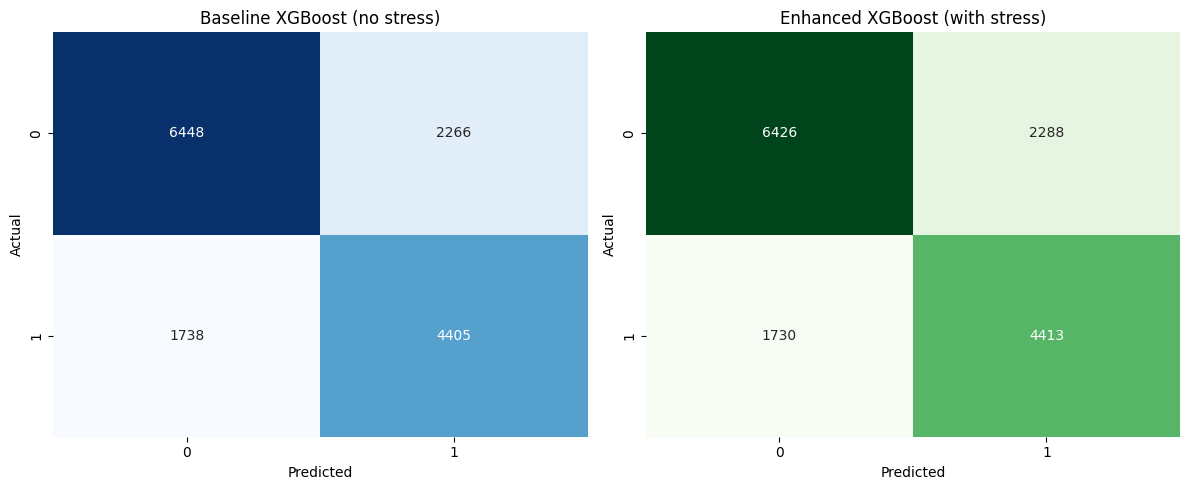

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Confusion matrices ---
cm_base = confusion_matrix(y_test, y_pred_tuned)   # from baseline tuned XGB
cm_enhanced = confusion_matrix(y_test_e, y_pred_enhanced)  # from enhanced XGB

fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.heatmap(cm_base, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title("Baseline XGBoost (no stress)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_enhanced, annot=True, fmt="d", cmap="Greens", cbar=False, ax=axes[1])
axes[1].set_title("Enhanced XGBoost (with stress)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

In [71]:
full_alz_scaled = scaler.fit_transform(new_alz_df)

full_alz_scaled = pd.DataFrame(
    full_alz_scaled,
    columns=new_alz_df.columns,
    index=new_alz_df.index
)
full_alz_scaled

,age,education_level,bmi,cognitive_test_score,alzheimer_s_diagnosis,country_Australia,country_Brazil,country_Canada,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Mexico,country_Norway,country_Russia,country_Saudi Arabia,country_South Africa,country_South Korea,country_Spain,country_Sweden,country_UK,country_USA,gender_Male,physical_activity_level_Low,physical_activity_level_Medium,smoking_status_Former,smoking_status_Never,alcohol_consumption_Occasionally,alcohol_consumption_Regularly,diabetes_Yes,hypertension_Yes,cholesterol_level_Normal,family_history_of_alzheimer_s_Yes,depression_level_Low,depression_level_Medium,sleep_quality_Good,sleep_quality_Poor,dietary_habits_Healthy,dietary_habits_Unhealthy,air_pollution_exposure_Low,air_pollution_exposure_Medium,employment_status_Retired,employment_status_Unemployed,marital_status_Single,marital_status_Widowed,genetic_risk_factor_apoe_ε4_allele_Yes,social_engagement_level_Low,social_engagement_level_Medium,income_level_Low,income_level_Medium,stress_levels_Low,stress_levels_Medium,urban_vs_rural_living_Urban,stress_score
0,1.389398,-1.474299,1.305314,1.257660,-0.83959,-0.231774,-0.233446,-0.229313,-0.225417,-0.229281,-0.232419,-0.230287,-0.229736,-0.230611,-0.225614,-0.229151,-0.231484,-0.227715,-0.230902,-0.229995,4.368907,-0.228597,-0.227355,-0.226207,1.002899,-0.706957,1.417862,-0.70426,1.415114,1.417690,-0.706614,-0.497883,-0.651803,0.655180,-0.654530,1.414342,-0.708864,-0.715348,1.428817,1.417346,-0.705330,-0.704859,-0.706250,1.415671,-0.707964,1.396914,-0.70240,-0.497167,1.415671,-0.709207,-0.709507,1.422781,-0.706443,-0.709786,1.001657,-0.866635
1,0.002719,-0.432087,0.654689,0.017157,-0.83959,-0.231774,-0.233446,-0.229313,-0.225417,-0.229281,-0.232419,-0.230287,-0.229736,-0.230611,-0.225614,-0.229151,-0.231484,-0.227715,-0.230902,-0.229995,-0.228890,-0.228597,-0.227355,-0.226207,1.002899,-0.706957,1.417862,1.41993,-0.706657,-0.705373,-0.706614,-0.497883,-0.651803,0.655180,-0.654530,1.414342,-0.708864,1.397922,-0.699880,1.417346,-0.705330,-0.704859,1.415929,-0.706379,1.412502,-0.715864,1.42369,-0.497167,-0.706379,-0.709207,1.409429,-0.702849,-0.706443,-0.709786,1.001657,-1.293811
2,1.081247,1.652339,-0.814465,-1.074486,-0.83959,-0.231774,-0.233446,-0.229313,-0.225417,-0.229281,-0.232419,-0.230287,-0.229736,-0.230611,-0.225614,-0.229151,-0.231484,-0.227715,4.330833,-0.229995,-0.228890,-0.228597,-0.227355,-0.226207,-0.997110,-0.706957,-0.705287,-0.70426,-0.706657,1.417690,-0.706614,-0.497883,1.534205,0.655180,-0.654530,-0.707043,-0.708864,1.397922,-0.699880,-0.705544,-0.705330,-0.704859,1.415929,-0.706379,-0.707964,1.396914,-0.70240,-0.497167,1.415671,-0.709207,-0.709507,1.422781,-0.706443,-0.709786,-0.998346,-0.439459
3,-1.460997,1.304935,0.927532,0.811079,-0.83959,-0.231774,-0.233446,-0.229313,4.436228,-0.229281,-0.232419,-0.230287,-0.229736,-0.230611,-0.225614,-0.229151,-0.231484,-0.227715,-0.230902,-0.229995,-0.228890,-0.228597,-0.227355,-0.226207,1.002899,1.414513,-0.705287,-0.70426,1.415114,-0.705373,1.415199,2.008504,-0.651803,0.655180,-0.654530,-0.707043,1.410708,-0.715348,-0.699880,1.417346,-0.705330,-0.704859,1.415929,1.415671,-0.707964,1.396914,-0.70240,-0.497167,-0.706379,-0.709207,-0.709507,1.422781,1.415543,-0.709786,-0.998346,1.696420
4,-1.075808,-1.126895,0.675677,-0.776765,-0.83959,-0.231774,-0.233446,-0.229313,-0.225417,-0.229281,-0.232419,-0.230287,-0.229736,-0.230611,-0.225614,-0.229151,-0.231484,-0.227715,-0.230902,-0.229995,-0.228890,4.374512,-0.227355,-0.226207,-0.997110,-0.706957,-0.705287,1.41993,-0.706657,-0.705373,-0.706614,2.008504,-0.651803,0.655180,-0.654530,-0.707043,-0.708864,-0.715348,1.428817,-0.705544,1.417776,-0.704859,-0.706250,-0.706379,-0.707964,-0.715864,-0.70240,-0.497167,1.415671,-0.709207,-0.709507,1.422781,-0.706443,-0.709786,-0.998346,0.842068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [72]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score  # Silhouette metrics
from pandas.api.types import CategoricalDtype

# Run k-means
kmeans = KMeans(
    n_clusters=4, # Set Cluster number
    n_init=25, # Set number of starts
    max_iter=100, # Set max iterations
    random_state=1234, # Set random state
    algorithm="lloyd"   # classic Lloyd's algorithm
).fit(full_alz_scaled) # Fit to scaled data

kmeans.labels_

array([0, 0, 3, ..., 0, 1, 1], shape=(74283,), dtype=int32)

In [73]:
new_alz_df["cluster"] = kmeans.labels_

cluster_sizes = new_alz_df["cluster"].value_counts().sort_index() # Count samples in each cluster
print(cluster_sizes)
new_alz_df

cluster
0    15789
1    23540
2     3651
3    31303
Name: count, dtype: int64


,age,education_level,bmi,cognitive_test_score,alzheimer_s_diagnosis,country_Australia,country_Brazil,country_Canada,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Mexico,country_Norway,country_Russia,country_Saudi Arabia,country_South Africa,country_South Korea,country_Spain,country_Sweden,country_UK,country_USA,gender_Male,physical_activity_level_Low,physical_activity_level_Medium,smoking_status_Former,smoking_status_Never,alcohol_consumption_Occasionally,alcohol_consumption_Regularly,diabetes_Yes,hypertension_Yes,cholesterol_level_Normal,family_history_of_alzheimer_s_Yes,depression_level_Low,depression_level_Medium,sleep_quality_Good,sleep_quality_Poor,dietary_habits_Healthy,dietary_habits_Unhealthy,air_pollution_exposure_Low,air_pollution_exposure_Medium,employment_status_Retired,employment_status_Unemployed,marital_status_Single,marital_status_Widowed,genetic_risk_factor_apoe_ε4_allele_Yes,social_engagement_level_Low,social_engagement_level_Medium,income_level_Low,income_level_Medium,stress_levels_Low,stress_levels_Medium,urban_vs_rural_living_Urban,stress_score,cluster
0,90,1,33.0,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,1,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,4.0,0
1,72,7,29.9,65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,3.0,0
2,86,19,22.9,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,5.0,3
3,53,17,31.2,81,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,1,0,0,10.0,1
4,58,3,30.0,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,8.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74278,60,3,22.6,42,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,4.0,3
74279,58,18,30.6,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,8.0,2
74280,57,13,28.2,61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,1,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,4.0,0
74281,73,7,29.0,97,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,9.0,1


In [74]:
cols_to_scale = full_alz_scaled.columns

# Extract cluster centers
centers_df = (
    pd.DataFrame(kmeans.cluster_centers_, columns=cols_to_scale)
    .assign(cluster=np.arange(0, 4))
    .loc[:, ["cluster"] + cols_to_scale.tolist()]
)
# Convert data to long form
center_long = (
    centers_df
    .melt(id_vars=["cluster"], var_name="features", value_name="values")
    .copy()
)
# Order variables alphabetically
sorted_features = sorted([c for c in centers_df.columns if c != "cluster"])
# Make 'features' an ordered categorical (so plot keeps our chosen order)
center_long["features"] = center_long["features"].astype(
    CategoricalDtype(categories=sorted_features, ordered=True)
)
# Turn off dark mode
plt.style.use('default')
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    "figure.facecolor": "white",   # ensure white figure background
    "axes.facecolor": "white",     # ensure white axes background
    "savefig.facecolor": "white",  # ensure saved figures are white
})

c:\Users\patbe\Machine Leaning Project\ml_env\Lib\site-packages\plotnine\themes\themeable.py:2486: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This parameter will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


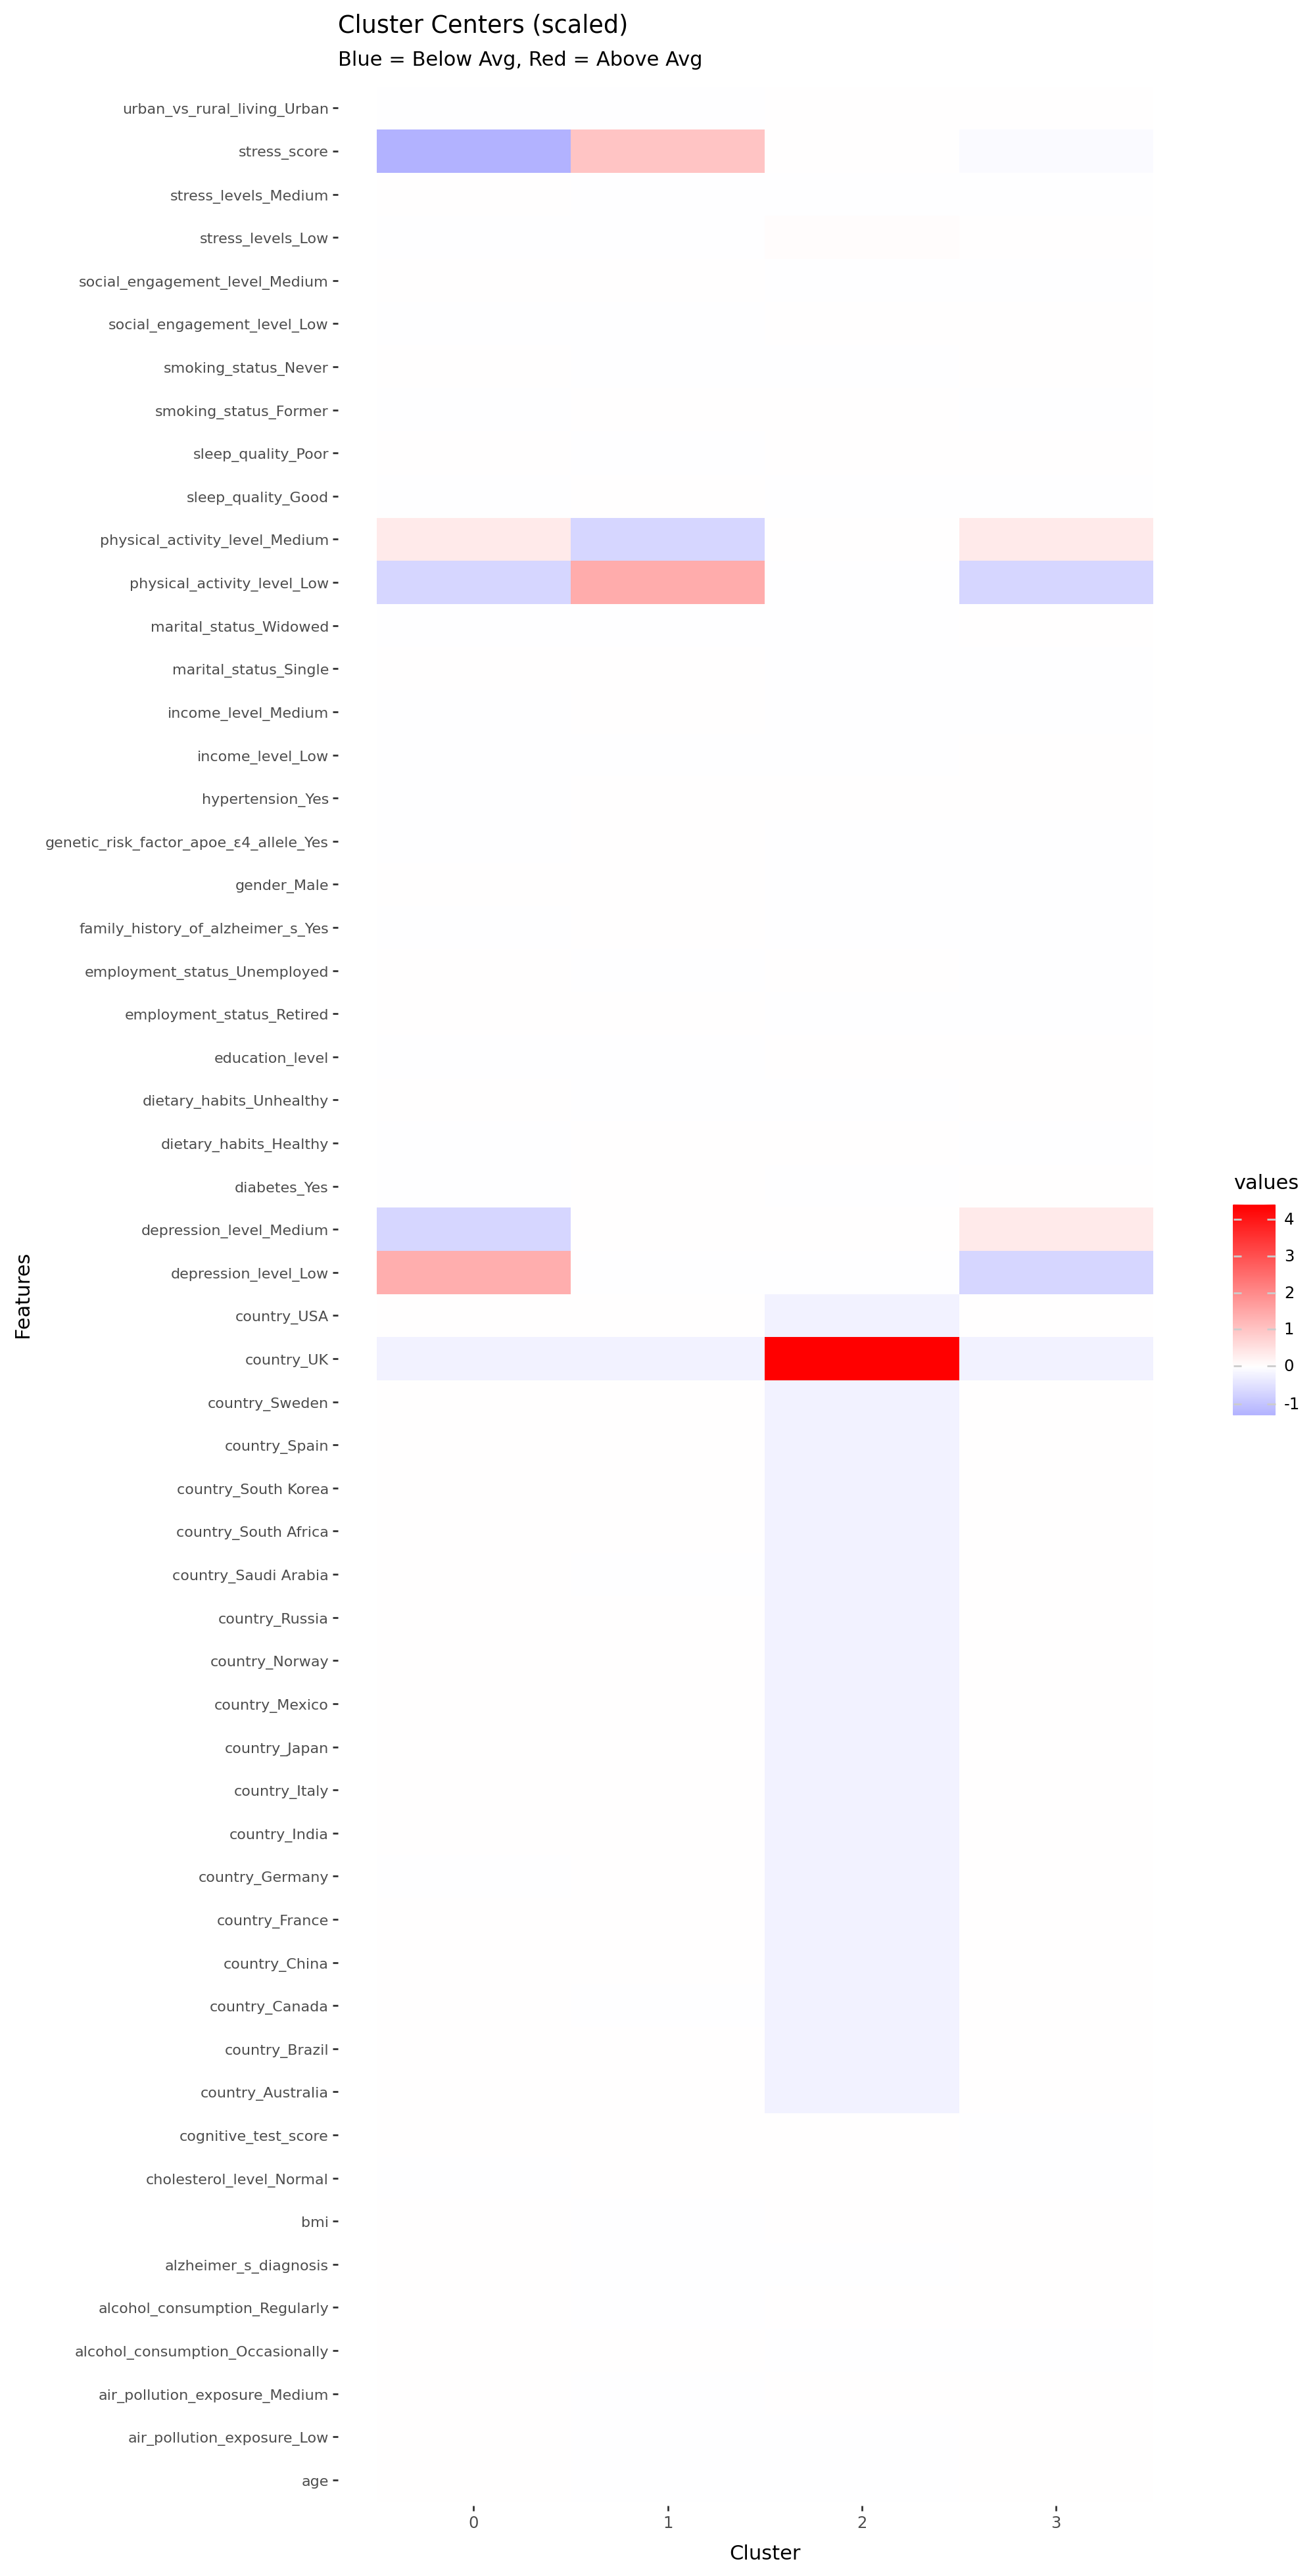

In [75]:
from plotnine import (
    ggplot, aes, geom_tile, theme_bw, scale_fill_gradient2, theme, element_blank,
    labs, coord_flip, scale_y_continuous, element_text
)

# Build the heatmap
g_heat_1 = (
    ggplot(data=center_long, mapping=aes(x="features", y="cluster", fill="values"))
    + scale_y_continuous(breaks=list(range(0, 4)))       # y-axis breaks for clusters
    + geom_tile()
    + theme_bw()
    + scale_fill_gradient2(
        low="blue", mid="white", high="red",
        midpoint=0, na_value="grey"
    )
    + theme(
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        panel_border=element_blank(),
        panel_background=element_blank()
    )
    + labs(
        x="Features",
        y="Cluster",
        title="Cluster Centers (scaled)",
        subtitle="Blue = Below Avg, Red = Above Avg"
    )
    + coord_flip()
)

# Make the figure tall enough for all labels and add margin so they don’t clip
n_feats = center_long['features'].nunique()
height = max(6, 0.35 * n_feats)  # tweak 0.35 if needed

g_heat_1 = g_heat_1 + theme(
    figure_size=(10, height),  # width, height (inches)
    subplots_adjust={'left': 0.32, 'right': 0.98, 'top': 0.92, 'bottom': 0.12},
    axis_text_y=element_text(size=8)  # slightly smaller y labels
)

# Render
g_heat_1


In [76]:
# Run k-means with more clusters
kmeans = KMeans(
    n_clusters=6, # Set Cluster number
    n_init=25, # Set number of starts
    max_iter=100, # Set max iterations
    random_state=1234, # Set random state
    algorithm="lloyd"   # classic Lloyd's algorithm
).fit(full_alz_scaled) # Fit to scaled data

kmeans.labels_

new_alz_df["cluster"] = kmeans.labels_

cluster_sizes = new_alz_df["cluster"].value_counts().sort_index() # Count samples in each cluster
print(cluster_sizes)

cluster
0     3662
1     3711
2     3751
3     3787
4    19965
5    39407
Name: count, dtype: int64


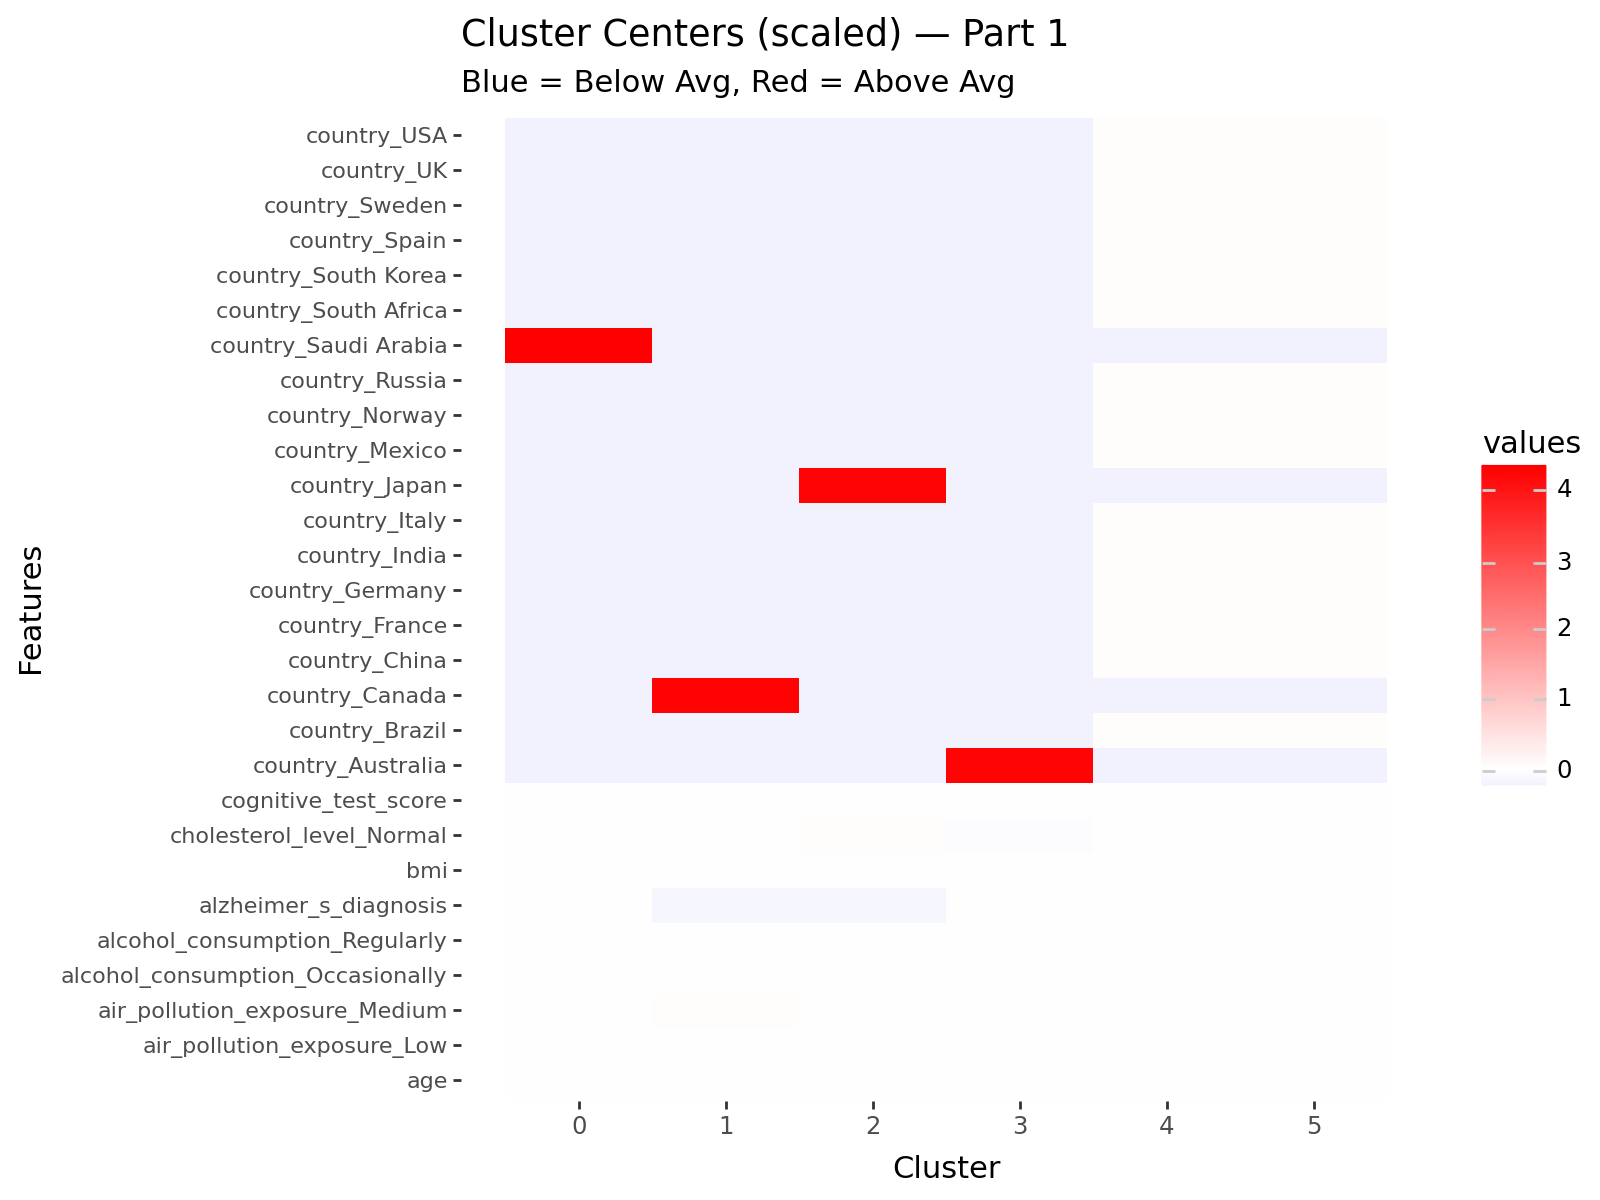

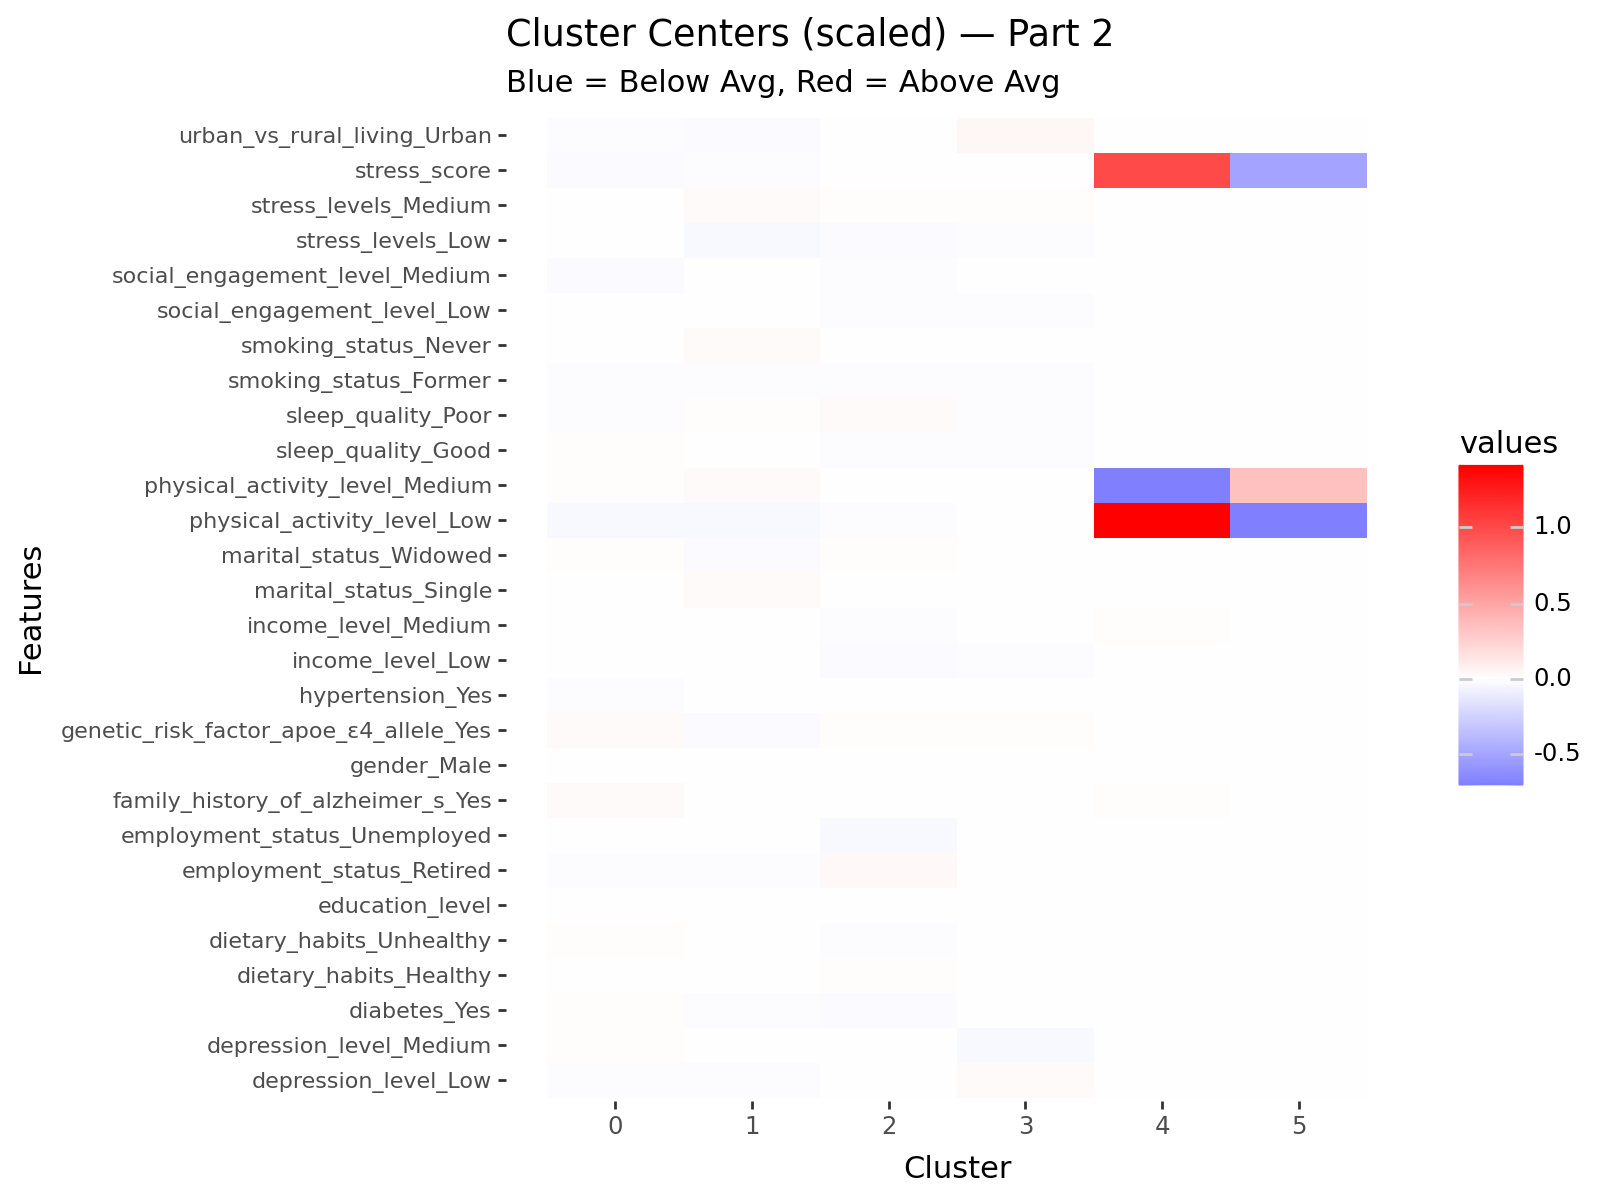

In [77]:
from math import ceil
from pandas.api.types import CategoricalDtype
from plotnine import (
    ggplot, aes, geom_tile, theme_bw, theme, element_blank, element_text,
    labs, coord_flip, scale_fill_gradient2, scale_y_continuous
)

# Extract cluster centers with correct columns
centers_df = (
    pd.DataFrame(kmeans.cluster_centers_, columns=full_alz_scaled.columns.astype(str))
    .assign(cluster=np.arange(kmeans.n_clusters))
)

# Melt into long form
center_long = centers_df.melt(
    id_vars="cluster", var_name="features", value_name="values"
).copy()

# Ensure features are ordered consistently
sorted_features = sorted([c for c in centers_df.columns if c != "cluster"])
center_long["features"] = center_long["features"].astype(
    CategoricalDtype(categories=sorted_features, ordered=True)
)


features_all = list(center_long["features"].cat.categories)
mid = ceil(len(features_all) / 2)
feat_A = features_all[:mid]
feat_B = features_all[mid:]

def plot_subset(subset_feats, title_suffix):
    df_sub = center_long[center_long["features"].isin(subset_feats)].copy()
    # Re-categorize to keep order inside the subset
    df_sub["features"] = df_sub["features"].astype(
        CategoricalDtype(categories=subset_feats, ordered=True)
    )
    n_clusters = 6  # adjust if needed
    return (
        ggplot(df_sub, aes(x="features", y="cluster", fill="values"))
        + geom_tile()
        + theme_bw()
        + scale_y_continuous(breaks=list(range(n_clusters)))
        + scale_fill_gradient2(low="blue", mid="white", high="red",
                               midpoint=0, na_value="grey")
        + theme(
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),
            panel_background=element_blank(),
            figure_size=(8, max(6, len(subset_feats) * 0.20)),
            axis_text_y=element_text(size=8)
        )
        + labs(x="Features", y="Cluster",
               title=f"Cluster Centers (scaled) — {title_suffix}",
               subtitle="Blue = Below Avg, Red = Above Avg")
        + coord_flip()
    )

g_heat_A = plot_subset(feat_A, "Part 1")
g_heat_B = plot_subset(feat_B, "Part 2")

g_heat_A.show()
# then render the second:
g_heat_B.show()


In [78]:
# Crosstab of Diagnosis by Cluster
cluster_diagnosis_ct = pd.crosstab(new_alz_df["cluster"], new_alz_df["alzheimer_s_diagnosis"])
print(cluster_diagnosis_ct)

# Normalize to see proportions
cluster_diagnosis_pct = cluster_diagnosis_ct.div(cluster_diagnosis_ct.sum(axis=1), axis=0)
print(cluster_diagnosis_pct)

alzheimer_s_diagnosis      0      1
cluster                            
0                       2145   1517
1                       2444   1267
2                       2478   1273
3                       2262   1525
4                      11526   8439
5                      22715  16692
alzheimer_s_diagnosis         0         1
cluster                                  
0                      0.585745  0.414255
1                      0.658583  0.341417
2                      0.660624  0.339376
3                      0.597307  0.402693
4                      0.577310  0.422690
5                      0.576420  0.423580


In [79]:
# Get descriptive stats for each cluster
cluster_summary = new_alz_df.groupby("cluster").mean(numeric_only=True)
cluster_summary

,age,education_level,bmi,cognitive_test_score,alzheimer_s_diagnosis,country_Australia,country_Brazil,country_Canada,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Mexico,country_Norway,country_Russia,country_Saudi Arabia,country_South Africa,country_South Korea,country_Spain,country_Sweden,country_UK,country_USA,gender_Male,physical_activity_level_Low,physical_activity_level_Medium,smoking_status_Former,smoking_status_Never,alcohol_consumption_Occasionally,alcohol_consumption_Regularly,diabetes_Yes,hypertension_Yes,cholesterol_level_Normal,family_history_of_alzheimer_s_Yes,depression_level_Low,depression_level_Medium,sleep_quality_Good,sleep_quality_Poor,dietary_habits_Healthy,dietary_habits_Unhealthy,air_pollution_exposure_Low,air_pollution_exposure_Medium,employment_status_Retired,employment_status_Unemployed,marital_status_Single,marital_status_Widowed,genetic_risk_factor_apoe_ε4_allele_Yes,social_engagement_level_Low,social_engagement_level_Medium,income_level_Low,income_level_Medium,stress_levels_Low,stress_levels_Medium,urban_vs_rural_living_Urban,stress_score
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,72.208902,9.505735,26.670863,64.905243,0.414255,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.499454,0.316767,0.341344,0.321409,0.334517,0.333697,0.327144,0.205898,0.292190,0.697979,0.315128,0.326597,0.341344,0.348170,0.319498,0.330694,0.340524,0.336701,0.335336,0.325778,0.335882,0.336428,0.339159,0.209175,0.332332,0.323321,0.337247,0.327690,0.330694,0.336428,0.488804,5.955489
1,71.770682,9.475613,26.818378,64.680949,0.341417,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.495823,0.312854,0.346807,0.323902,0.345729,0.327405,0.330369,0.191054,0.297224,0.698464,0.302614,0.326327,0.339262,0.341417,0.334142,0.337375,0.335759,0.325519,0.352466,0.325519,0.338723,0.351118,0.316626,0.187551,0.334411,0.335759,0.335220,0.330639,0.316626,0.345998,0.487200,5.987065
2,71.846174,9.489203,26.753479,64.118102,0.339376,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.493468,0.324980,0.334577,0.324180,0.331112,0.333778,0.341509,0.188216,0.296721,0.715543,0.296188,0.330579,0.335644,0.328446,0.343375,0.339376,0.326580,0.332445,0.338310,0.350040,0.316182,0.341509,0.336710,0.203679,0.327113,0.327113,0.323114,0.322847,0.319381,0.342042,0.495068,6.027193
3,71.782942,9.531819,26.875205,64.452337,0.402693,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.501452,0.329813,0.329020,0.325059,0.331133,0.322155,0.345656,0.202799,0.297597,0.683391,0.295485,0.346976,0.318458,0.332981,0.319778,0.334830,0.333509,0.339847,0.340111,0.332981,0.328756,0.343544,0.328756,0.205440,0.326116,0.332189,0.327172,0.334566,0.325059,0.343544,0.525746,6.003961
4,71.913449,9.446081,26.733799,64.701227,0.422690,0.0,0.061808,0.0,0.062309,0.062359,0.066216,0.063461,0.064363,0.0,0.059654,0.062710,0.064813,0.0,0.060055,0.060907,0.064212,0.063711,0.060806,0.061357,0.500476,1.000000,0.000000,0.336539,0.328024,0.338392,0.328024,0.198698,0.302930,0.702980,0.305084,0.331180,0.337040,0.341798,0.325419,0.335387,0.328074,0.328675,0.329677,0.333834,0.330478,0.341898,0.330829,0.198848,0.334986,0.339644,0.334986,0.336088,0.334836,0.330178,0.495367,8.385174
5,72.014997,9.503515,26.804514,64.675032,0.423580,0.0,0.066105,0.0,0.059583,0.062552,0.063060,0.062781,0.061893,0.0,0.061081,0.062273,0.063034,0.0,0.064988,0.063847,0.061309,0.061334,0.061842,0.060674,0.497957,0.000000,0.498338,0.331997,0.334636,0.330271,0.334331,0.199254,0.296597,0.698302,0.296419,0.334585,0.333443,0.337148,0.330322,0.329586,0.333621,0.3329

In [80]:
cluster_diag_summary = new_alz_df.groupby(["cluster", "alzheimer_s_diagnosis"]).mean(numeric_only=True)
print(cluster_diag_summary)


                                     age  education_level        bmi  \
cluster alzheimer_s_diagnosis                                          
0       0                      67.696503         9.492774  26.766900   
        1                      78.589321         9.524061  26.535069   
1       0                      67.750409         9.484043  26.886579   
        1                      79.525651         9.459353  26.686819   
2       0                      68.050847         9.523810  26.748184   
        1                      79.234093         9.421838  26.763786   
3       0                      67.149425         9.637047  26.905261   
        1                      78.655738         9.375738  26.830623   
4       0                      67.233732         9.444387  26.753887   
        1                      78.305012         9.448394  26.706363   
5       0                      67.349989         9.455822  26.788307   
        1                      78.363288         9.568416  26.82

In [81]:
# Crosstab of diagnosis per cluster
cluster_diagnosis_ct = pd.crosstab(new_alz_df["cluster"], new_alz_df["alzheimer_s_diagnosis"])

# Calculate prevalence (% Alzheimer’s)
cluster_diagnosis_ct["Alzheimers_Prevalence"] = (
    cluster_diagnosis_ct[1] / cluster_diagnosis_ct.sum(axis=1) * 100
)

print(cluster_diagnosis_ct)

alzheimer_s_diagnosis      0      1  Alzheimers_Prevalence
cluster                                                   
0                       2145   1517              41.425451
1                       2444   1267              34.141741
2                       2478   1273              33.937617
3                       2262   1525              40.269342
4                      11526   8439              42.268971
5                      22715  16692              42.357957


In [82]:
# Overall prevalence
overall_prevalence = (new_alz_df["alzheimer_s_diagnosis"].mean()) * 100

# Label clusters as High-Risk if prevalence is above overall average
cluster_diagnosis_ct["Risk_Level"] = np.where(
    cluster_diagnosis_ct["Alzheimers_Prevalence"] > overall_prevalence,
    "High-Risk",
    "Lower-Risk"
)

print("Overall Alzheimer’s prevalence:", round(overall_prevalence, 2), "%")
print(cluster_diagnosis_ct)


Overall Alzheimer’s prevalence: 41.35 %
alzheimer_s_diagnosis      0      1  Alzheimers_Prevalence  Risk_Level
cluster                                                               
0                       2145   1517              41.425451   High-Risk
1                       2444   1267              34.141741  Lower-Risk
2                       2478   1273              33.937617  Lower-Risk
3                       2262   1525              40.269342  Lower-Risk
4                      11526   8439              42.268971   High-Risk
5                      22715  16692              42.357957   High-Risk


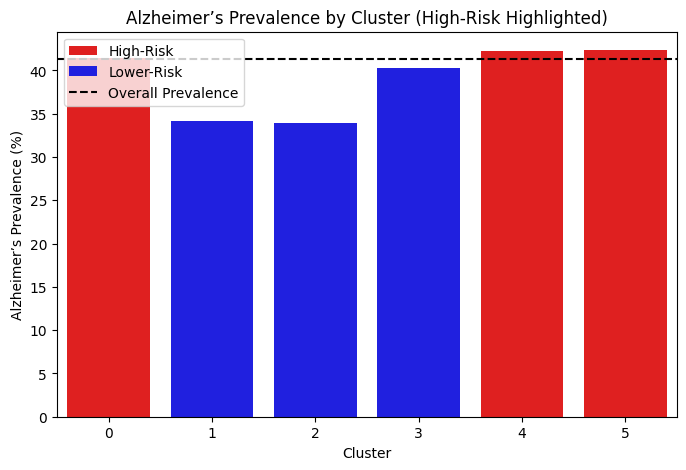

In [83]:
plt.figure(figsize=(8,5))
sns.barplot(
    x=cluster_diagnosis_ct.index,
    y=cluster_diagnosis_ct["Alzheimers_Prevalence"],
    hue=cluster_diagnosis_ct["Risk_Level"],
    palette={"High-Risk": "red", "Lower-Risk": "blue"}
)
plt.axhline(overall_prevalence, color="black", linestyle="--", label="Overall Prevalence")
plt.title("Alzheimer’s Prevalence by Cluster (High-Risk Highlighted)")
plt.xlabel("Cluster")
plt.ylabel("Alzheimer’s Prevalence (%)")
plt.legend()
plt.show()